In [2]:
import pandas as pd
import numpy as np
import time
import h5py
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU,TimeDistributed, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
import ast
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from scipy.stats import loguniform
# from pandas import read_csv
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime
from qkeras import *
today = datetime.date(datetime.now())

2022-09-09 22:07:09.068979: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-09 22:07:09.299864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 22:07:09.299963: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-09-09 22:07:20.248312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 22:07:20.248451: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 22:07:20.248500: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-CHSBCRQ): /proc/driver/nvidia/version does not exist


x-train-shape:  (379052, 20, 6)
y-train-shape:  (379052, 1)


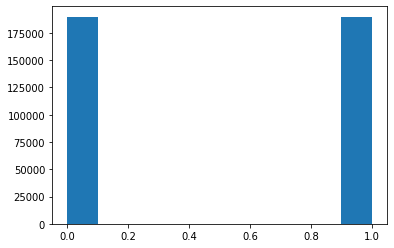

In [4]:
x_train = np.load('./x_train.npy')
y_train = np.load('./y_train.npy')

y_train = y_train[:,4:5]
plt.hist(y_train)

print("x-train-shape: ", x_train.shape)
print("y-train-shape: ", y_train.shape)

## Small GRU

In [5]:
model = Sequential()
model.add(GRU(5, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
              name = 'layer1', input_shape = (20,6)))
model.add(Dense(5, activation='relu', kernel_initializer='glorot_normal', name='layer2'))
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))


model.summary()

2022-09-09 22:07:24.524915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 5)                 195       
                                                                 
 layer2 (Dense)              (None, 5)                 30        
                                                                 
 output_sigmoid (Dense)      (None, 1)                 6         
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


## GRU

In [6]:
model = Sequential()
model.add(GRU(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001), 
              name = 'layer1', input_shape = (20,6)))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal', name='layer3')) 
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 20)                1680      
                                                                 
 layer3 (Dense)              (None, 64)                1344      
                                                                 
 output_sigmoid (Dense)      (None, 1)                 65        
                                                                 
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


## LSTM

In [7]:
model = Sequential()
model.add(LSTM(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
               name = 'layer1', input_shape = (20,6)))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal', name='layer3'))
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 20)                2160      
                                                                 
 layer3 (Dense)              (None, 64)                1344      
                                                                 
 output_sigmoid (Dense)      (None, 1)                 65        
                                                                 
Total params: 3,569
Trainable params: 3,569
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=10)
adam = Adam(lr = 0.0002)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 256,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'lstm/model_toptag_lstm.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)

/home/yihuic/miniconda3/envs/hls4ml-tutorial/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
1185/1185 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.8179
Epoch 1: val_loss improved from inf to 0.39921, saving model to lstm/model_toptag_lstm.h5
1185/1185 [==============================] - 27s 20ms/step - loss: 0.4222 - accuracy: 0.8179 - val_loss: 0.3992 - val_accuracy: 0.8372
Epoch 2/150
1182/1185 [============================>.] - ETA: 0s - loss: 0.3764 - accuracy: 0.8450
Epoch 2: val_loss improved from 0.39921 to 0.38278, saving model to lstm/model_toptag_lstm.h5
1185/1185 [==============================] - 22s 19ms/step - loss: 0.3764 - accuracy: 0.8450 - val_loss: 0.3828 - val_accuracy: 0.8416
Epoch 3/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.8484
Epoch 3: val_loss improved from 0.38278 to 0.35878, saving model to lstm/model_toptag_lstm.h5
1185/1185 [==============================] - 23s 19ms/step - loss: 0.3672 - accuracy: 0.8484 - val_loss: 0.3588 - val_accuracy: 0.8517
Epoch 4/150
1183/118

In [ ]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('training_plot_loss.png')
plt.show()


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('training_plot_accuracy.png')
plt.show()

## Check Performance

(array([10044.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  9907.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

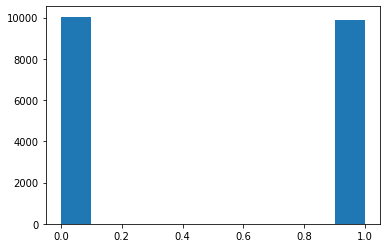

In [8]:
x_test = np.load('./x_test.npy')
y_test = np.load('./y_test.npy')

plt.hist(y_test)

In [ ]:
from sklearn.metrics import roc_auc_score

labels = ['j_t']
y_keras = qgru_model.predict(x_test)
auc_score = roc_auc_score(y_test, y_keras)
print("AUC score:", auc_score)